## Data Generation

### created by Yuying Liu, 04/30/2020

This script is used for generating data sets for multiscale HiTS experiments. Here, we consider 5 nonlinear systems: a hyperbolic fixed point, a damped cubic oscillator, the Van der Pol oscillator, a Hopf normal form, and the Lorenz system. Simulations are conducted using scipy.integrate.solve_ivp() and considered as ground truth.

In [1]:
import os
import numpy as np
import scipy as sp
from scipy import integrate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch

In [2]:
# paths
data_dir = '../../data/'
hyperbolic_dir = os.path.join(data_dir, 'Hyperbolic')
cubic_dir = os.path.join(data_dir, 'Cubic')
vdp_dir = os.path.join(data_dir, 'VanDerPol')
hopf_dir = os.path.join(data_dir, 'Hopf')
lorenz_dir = os.path.join(data_dir, 'Lorenz')

In [3]:
# adjustable parameters
dt = 0.0005       # set to 5e-4 for Lorenz
noise = 0.      # for study of noisy measurements, we use noise=0.01, 0.02; otherwise we leave it as 0.
n_forward = 5
total_steps = 1024 * n_forward
t = np.linspace(0, (total_steps)*dt, total_steps+1)

In [10]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25

# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)

# mesh grids
n_train = 100
n_timesteps = 500
x = np.linspace(-5, 5, 124)
y = np.linspace(-5, 5, 124)
t = np.linspace(0, 8*np.pi, 500)

dt = t[1] - t[0]

n_per_dim = 4


stride_size = int(len(x)/n_per_dim)
print("len x = ", len(x))
print("stride_size = ", stride_size)
        
op = torch.nn.Conv2d(1, 1, stride_size, stride=stride_size, padding=0)
#averaging
op.weight.data[0,0, :, :] = torch.ones(op.weight.data[0,0, :, :].size()) / (stride_size **2)

        
train_data = np.zeros((n_train, n_timesteps, n_per_dim**2))
print(train_data.shape)
for i in range(n_train):
    print("i = ", i)
    xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
    t = t + 10*dt

    # data
    Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
    averaged  = op(torch.tensor(Phi.T).unsqueeze(1).float())
    averaged = torch.flatten(averaged, start_dim=1, end_dim=-1)
#     Phi = torch.tensor(Phi.T).unsqueeze(1).float()
#     averaged = torch.flatten(Phi, start_dim=1, end_dim=-1)
#     print("averaged shape = ", averaged.shape)
    train_data[i,:,:] = averaged.detach().numpy()
    
print(train_data.shape)
np.save('../../data/toy1_4x4/train_data.npy', train_data)

len x =  124
stride_size =  31
(100, 500, 16)
i =  0
averaged shape =  torch.Size([500, 16])
i =  1
averaged shape =  torch.Size([500, 16])
i =  2
averaged shape =  torch.Size([500, 16])
i =  3
averaged shape =  torch.Size([500, 16])
i =  4
averaged shape =  torch.Size([500, 16])
i =  5
averaged shape =  torch.Size([500, 16])
i =  6
averaged shape =  torch.Size([500, 16])
i =  7
averaged shape =  torch.Size([500, 16])
i =  8
averaged shape =  torch.Size([500, 16])
i =  9
averaged shape =  torch.Size([500, 16])
i =  10
averaged shape =  torch.Size([500, 16])
i =  11
averaged shape =  torch.Size([500, 16])
i =  12
averaged shape =  torch.Size([500, 16])
i =  13
averaged shape =  torch.Size([500, 16])
i =  14
averaged shape =  torch.Size([500, 16])
i =  15
averaged shape =  torch.Size([500, 16])
i =  16
averaged shape =  torch.Size([500, 16])
i =  17
averaged shape =  torch.Size([500, 16])
i =  18
averaged shape =  torch.Size([500, 16])
i =  19
averaged shape =  torch.Size([500, 16])
i = 

In [6]:
31*4

124

In [13]:
# np.save('../../data/toy1_3x3/train_data.npy', train_data)

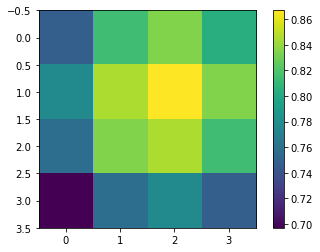

In [11]:
plt.imshow(train_data[2,0].reshape(n_per_dim, n_per_dim))
plt.colorbar()

### Hyperbolic fixed point

\begin{split}
    \dot{x} &= \mu x \\
    \dot{y} &= \lambda(y-x^2)     
\end{split}

In [ ]:
# system
mu = -0.05
lam = -1.0
def hyperbolic_rhs(x):
    return np.array([mu*x[0], lam*(x[1]-x[0]**2)])

# simulation parameters
np.random.seed(2)
n = 2

# dataset 
n_train = 1600
n_val = 320
n_test = 320

In [ ]:
# simulate training trials 
train_data = np.zeros((n_train, total_steps+1, n))
print('generating training trials ...')
for i in tqdm(range(n_train)):
    x_init = np.random.uniform(-1.0, 1.0, n)
    sol = sp.integrate.solve_ivp(lambda _, x: hyperbolic_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    train_data[i, :, :] = sol.y.T

# simulate validation trials 
val_data = np.zeros((n_val, total_steps+1, n))
print('generating validation trials ...')
for i in tqdm(range(n_val)):
    x_init = np.random.uniform(-1.0, 1.0, n)
    sol = sp.integrate.solve_ivp(lambda _, x: hyperbolic_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    val_data[i, :, :] = sol.y.T
    
# simulate test trials
test_data = np.zeros((n_test, total_steps+1, n))
print('generating testing trials ...')
for i in tqdm(range(n_test)):
    x_init = np.random.uniform(-1.0, 1.0, n)
    sol = sp.integrate.solve_ivp(lambda _, x: hyperbolic_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    test_data[i, :, :] = sol.y.T
    
# add noise
train_data += noise*train_data.std(1).mean(0)*np.random.randn(*train_data.shape)
val_data += noise*val_data.std(1).mean(0)*np.random.randn(*val_data.shape)
test_data += noise*test_data.std(1).mean(0)*np.random.randn(*test_data.shape)
        
# save data
np.save(os.path.join(hyperbolic_dir, 'train_noise{}.npy'.format(noise)), train_data)
np.save(os.path.join(hyperbolic_dir, 'val_noise{}.npy'.format(noise)), val_data)
np.save(os.path.join(hyperbolic_dir, 'test_noise{}.npy'.format(noise)), test_data)

### Cubic oscillator

\begin{split}
    \dot{x} &= -0.1x^3 + 2y^3 \\
    \dot{y} &= -2x^3 - 0.1y^3
\end{split}

In [ ]:
# system
def cubic_rhs(x):
    return np.array([-0.1*x[0]**3+2*x[1]**3, 
                     -2*x[0]**3-0.1*x[1]**3])

# simulation parameters
np.random.seed(2)
n = 2

# dataset 
n_train = 3200
n_val = 320
n_test = 320

In [ ]:
# simulate training trials 
train_data = np.zeros((n_train, total_steps+1, n))
print('generating training trials ...')
for i in tqdm(range(n_train)):
    x_init = np.random.uniform(-1.0, 1.0, n)
    sol = sp.integrate.solve_ivp(lambda _, x: cubic_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    train_data[i, :, :] = sol.y.T

# simulate validation trials 
val_data = np.zeros((n_val, total_steps+1, n))
print('generating validation trials ...')
for i in tqdm(range(n_val)):
    x_init = np.random.uniform(-1.0, 1.0, n)
    sol = sp.integrate.solve_ivp(lambda _, x: cubic_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    val_data[i, :, :] = sol.y.T
    
# simulate test trials
test_data = np.zeros((n_test, total_steps+1, n))
print('generating testing trials ...')
for i in tqdm(range(n_test)):
    x_init = np.random.uniform(-1.0, 1.0, n)
    sol = sp.integrate.solve_ivp(lambda _, x: cubic_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    test_data[i, :, :] = sol.y.T
    
# add noise
train_data += noise*train_data.std(1).mean(0)*np.random.randn(*train_data.shape)
val_data += noise*val_data.std(1).mean(0)*np.random.randn(*val_data.shape)
test_data += noise*test_data.std(1).mean(0)*np.random.randn(*test_data.shape)    

# save data
np.save(os.path.join(cubic_dir, 'train_noise{}.npy'.format(noise)), train_data)
np.save(os.path.join(cubic_dir, 'val_noise{}.npy'.format(noise)), val_data)
np.save(os.path.join(cubic_dir, 'test_noise{}.npy'.format(noise)), test_data)

### Van der Pol

\begin{split}
    \dot{x} &= y \\
    \dot{y} &= \mu(1-x^2)y - x   
\end{split}

where $\mu=2.0$

In [ ]:
# system
mu = 2.0
def van_der_pol_rhs(x):
    return np.array([x[1], mu*(1-x[0]**2)*x[1]-x[0]])

# simulation parameters
np.random.seed(2)
n = 2

# dataset 
n_train = 3200
n_val = 320
n_test = 320

In [ ]:
# simulate training trials 
train_data = np.zeros((n_train, total_steps+1, n))
print('generating training trials ...')
for i in tqdm(range(n_train)):
    x_init = [np.random.uniform(-2.0, 2.0), np.random.uniform(-4.0, 4.0)]
    sol = sp.integrate.solve_ivp(lambda _, x: van_der_pol_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    train_data[i, :, :] = sol.y.T

# simulate validation trials 
val_data = np.zeros((n_val, total_steps+1, n))
print('generating validation trials ...')
for i in tqdm(range(n_val)):
    x_init = [np.random.uniform(-2.0, 2.0), np.random.uniform(-2.0, 2.0)]    # make sure we have seen them in training set
    sol = sp.integrate.solve_ivp(lambda _, x: van_der_pol_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    val_data[i, :, :] = sol.y.T
    
# simulate test trials
test_data = np.zeros((n_test, total_steps+1, n))
print('generating testing trials ...')
for i in tqdm(range(n_test)):
    x_init = [np.random.uniform(-2.0, 2.0), np.random.uniform(-2.0, 2.0)]
    sol = sp.integrate.solve_ivp(lambda _, x: van_der_pol_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    test_data[i, :, :] = sol.y.T
        
# add noise
train_data += noise*train_data.std(1).mean(0)*np.random.randn(*train_data.shape)
val_data += noise*val_data.std(1).mean(0)*np.random.randn(*val_data.shape)
test_data += noise*test_data.std(1).mean(0)*np.random.randn(*test_data.shape)
        
# save data
np.save(os.path.join(vdp_dir, 'train_noise{}.npy'.format(noise)), train_data)
np.save(os.path.join(vdp_dir, 'val_noise{}.npy'.format(noise)), val_data)
np.save(os.path.join(vdp_dir, 'test_noise{}.npy'.format(noise)), test_data)

### Hopf bifurcation

\begin{split}
    \dot{\mu} &= 0 \\
    \dot{x} &= \mu x + y -x(x^2+y^2) \\
    \dot{y} &= \mu y - x -y(x^2+y^2)
\end{split}

In [ ]:
# system
def hopf_rhs(x):
    return np.array([0, x[0]*x[1]+x[2]-x[1]*(x[1]**2+x[2]**2),
                    -x[1]+x[0]*x[2]-x[2]*(x[1]**2+x[2]**2)])

# simulation parameters
np.random.seed(2)
n = 3

# dataset 
n_train = 3200
n_val = 320
n_test = 320

In [ ]:
# simulate training trials 
train_data = np.zeros((n_train, total_steps+1, n))
print('generating training trials ...')
for i in tqdm(range(n_train)):
    x_init = [np.random.uniform(-0.2, 0.6), np.random.uniform(-1, 2), np.random.uniform(-1, 1)]
    sol = sp.integrate.solve_ivp(lambda _, x: hopf_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    train_data[i, :, :] = sol.y.T

# simulate validation trials 
val_data = np.zeros((n_val, total_steps+1, n))
print('generating validation trials ...')
for i in tqdm(range(n_val)):
    x_init = [np.random.uniform(-0.2, 0.6), np.random.uniform(-1, 2), np.random.uniform(-1, 1)]
    sol = sp.integrate.solve_ivp(lambda _, x: hopf_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    val_data[i, :, :] = sol.y.T
    
# simulate test trials
test_data = np.zeros((n_test, total_steps+1, n))
print('generating testing trials ...')
for i in tqdm(range(n_test)):
    x_init = [np.random.uniform(-0.2, 0.6), np.random.uniform(-1, 2), np.random.uniform(-1, 1)]
    sol = sp.integrate.solve_ivp(lambda _, x: hopf_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    test_data[i, :, :] = sol.y.T
    
# add noise
train_data += noise*train_data.std(1).mean(0)*np.random.randn(*train_data.shape)
val_data += noise*val_data.std(1).mean(0)*np.random.randn(*val_data.shape)
test_data += noise*test_data.std(1).mean(0)*np.random.randn(*test_data.shape)
        
# save data
np.save(os.path.join(hopf_dir, 'train_noise{}.npy'.format(noise)), train_data)
np.save(os.path.join(hopf_dir, 'val_noise{}.npy'.format(noise)), val_data)
np.save(os.path.join(hopf_dir, 'test_noise{}.npy'.format(noise)), test_data)

### Lorenz

\begin{split}
    \dot{x} &= \sigma(y-x) \\
    \dot{y} &= x(\rho-z)-y \\
    \dot{z} &= xy - \beta z    
\end{split}

where $\sigma=10, \rho=28, \beta=8/3$

In [4]:
# system
sigma = 10
rho = 28
beta = 8/3
    
def lorenz_rhs(x):
    return np.array([sigma*(x[1]-x[0]), x[0]*(rho-x[2])-x[1], x[0]*x[1]-beta*x[2]])

# simulation parameters
np.random.seed(2)
warmup = 10000
n = 3

# dataset 
n_train = 6400
n_val = 640
n_test = 640

In [5]:
# simulate training trials 
pre_t = np.linspace(0, warmup*dt, warmup+1)

train_data = np.zeros((n_train, total_steps+1, n))
print('generating training trials ...')
x_init = np.random.uniform(-0.1, 0.1, n)
sol = sp.integrate.solve_ivp(lambda _, x: lorenz_rhs(x), [0, warmup*dt], x_init, t_eval=pre_t)
for i in tqdm(range(n_train)):
    x_init = sol.y[:, -1].T
    sol = sp.integrate.solve_ivp(lambda _, x: lorenz_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    train_data[i, :, :] = sol.y.T

# simulate validation trials 
val_data = np.zeros((n_val, total_steps+1, n))
print('generating validation trials ...')
x_init = np.random.uniform(-0.1, 0.1, n)
sol = sp.integrate.solve_ivp(lambda _, x: lorenz_rhs(x), [0, warmup*dt], x_init, t_eval=pre_t)
for i in tqdm(range(n_val)):
    x_init = sol.y[:, -1].T    
    sol = sp.integrate.solve_ivp(lambda _, x: lorenz_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    val_data[i, :, :] = sol.y.T
    
# simulate test trials
test_data = np.zeros((n_test, total_steps+1, n))
print('generating testing trials ...')
x_init = np.random.uniform(-0.1, 0.1, n)
sol = sp.integrate.solve_ivp(lambda _, x: lorenz_rhs(x), [0, warmup*dt], x_init, t_eval=pre_t)
for i in tqdm(range(n_test)):
    x_init = sol.y[:, -1].T
    sol = sp.integrate.solve_ivp(lambda _, x: lorenz_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    test_data[i, :, :] = sol.y.T
    
# add noise
train_data += noise*train_data.std(1).mean(0)*np.random.randn(*train_data.shape)
val_data += noise*val_data.std(1).mean(0)*np.random.randn(*val_data.shape)
test_data += noise*test_data.std(1).mean(0)*np.random.randn(*test_data.shape)
        
# save data
np.save(os.path.join(lorenz_dir, 'train_noise{}.npy'.format(noise)), train_data)
np.save(os.path.join(lorenz_dir, 'val_noise{}.npy'.format(noise)), val_data)
np.save(os.path.join(lorenz_dir, 'test_noise{}.npy'.format(noise)), test_data)

generating training trials ...



generating validation trials ...



generating testing trials ...


FileNotFoundError: [Errno 2] No such file or directory: '../../data/Lorenz\\train_noise0.0.npy'

In [10]:
np.save(os.path.join(lorenz_dir, 'train_noise{}.npy'.format(noise)), train_data)
np.save(os.path.join(lorenz_dir, 'val_noise{}.npy'.format(noise)), val_data)
np.save(os.path.join(lorenz_dir, 'test_noise{}.npy'.format(noise)), test_data)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/Lorenz\\train_noise0.0.npy'